<a href="https://colab.research.google.com/github/xFlodz/neural_networks/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%20%E2%84%969%20%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9%20%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8%20%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9%20%D0%B8%20%D1%80%D0%B0%D0%B7%D0%B2%D0%B5%D1%80%D1%82%D1%8B%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №9. Сравнение моделей классификации изображений и развертывание API**


## **Цель работы**


Провести сравнительный анализ ранее обученных моделей классификации изображений (работы 2-5), выбрать лучшую по метрикам качества, развернуть ее в виде API и создать пользовательский интерфейс с помощью Streamlit.

## **Раздел 1. Подготовка и анализ моделей**


1. Загрузить выбранный датасет для классификации изображений
2. Загрузить ранее обученные модели (из практических работ 2-5)
3. Сравнить модели по метрикам качества:
   - Точность (accuracy)
   - Полнота (recall)
   - Precision
   - F1-мера
   - Время инференса
4. Создать сводный DataFrame с результатами всех моделей
5. Визуализировать результаты сравнения с помощью графиков
6. Построить матрицы ошибок для каждой модели
7. Выбрать лучшую модель по F1-мере
8. Сохранить лучшую модель

### Загрузка и подготовка датасета

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow
from keras.models import load_model
from imutils import paths
import numpy as np
import random
import pickle
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!unzip /content/drive/MyDrive/datasets/animals.zip -d animals

In [ ]:
imagesPath = sorted(list(paths.list_images('/content/animals/')))
random.shuffle(imagesPath)

Загрузка изображений в формате (64, 64, 3)

In [ ]:
def load_images(imagePaths, compression_size = 32):
  """
  Функция для загрузки изображений и преобразования их к нужной размерности.

  Args:
    imagePaths: список путей к изображениям.
    compression_size: размер сжатия изображения

  Returns:
    data: список векторов признаков (сжатых изображений).
    labels: список меток классов.
  """

  data = []
  labels = []

  for imagePath in imagePaths:
    image = cv2.imread(imagePath)

    image = cv2.resize(image, (compression_size, compression_size))

    data.append(image)

    label = imagePath.split(os.path.sep)[-2]

    labels.append(label)

  return data, labels

data, labels = load_images(imagesPath, 64)

In [ ]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

print(data.shape)

(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.2, random_state=42)

lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

print(X_train.shape)
print(X_test.shape)

(7200, 64, 64, 3)
(5760, 64, 64, 3)
(1440, 64, 64, 3)


Загрузка изображений в формате (64, 64, 3) -> (12288)

In [ ]:
def load_flat_images(imagePaths, compression_size = 32):
  """
  Функция для загрузки изображений и преобразования их в векторы признаков.

  Args:
    imagePaths: список путей к изображениям.
    compression_size: размер сжатия изображения

  Returns:
    data: список векторов признаков (сжатых изображений, преобразованных в векторы).
    labels: список меток классов.
  """

  data = []
  labels = []

  for imagePath in imagePaths:

    image = cv2.imread(imagePath)

    image = cv2.resize(image, (compression_size, compression_size)).flatten()

    data.append(image)

    label = imagePath.split(os.path.sep)[-2]

    labels.append(label)

  return data, labels

flat_data, flat_labels = load_flat_images(imagesPath, 64)

In [ ]:
flat_data = np.array(flat_data, dtype="float") / 255.0
flat_labels = np.array(flat_labels)

print(flat_data.shape)

(X_train_flat, X_test_flat, Y_train_flat, Y_test_flat) = train_test_split(flat_data, flat_labels, test_size=0.2, random_state=42)

flat_lb = LabelBinarizer()
Y_train_flat = lb.fit_transform(Y_train)
Y_test_flat = lb.transform(Y_test)

print(X_train_flat.shape)
print(X_test_flat.shape)

(7200, 12288)
(5760, 12288)
(1440, 12288)


### Получение метрик для моделей

In [ ]:
models = {
    "simple_dnn(work_№2)": load_model('/content/best_model.h5'),
    "simple_cnn(work_№3)": load_model('/content/best_model_my.keras'),
    "deep_cnn(work_№3)": load_model('/content/best_model_resnet_like.keras'),
    "residual_cnn(work_№4)": load_model('/content/best_model_new.keras'),
}

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

results = {}

for name, model in models.items():
    print(f"Получаем метрики для модели {name}")

    if name == "simple_dnn(work_№2)":
        test_loss, test_acc = model.evaluate(X_test_flat, Y_test_flat, verbose=0)

        y_pred_proba = model.predict(X_test_flat)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_test = np.argmax(Y_test_flat, axis=1)

    else:
        test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

        y_pred_proba = model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_test = np.argmax(Y_test, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': cm,
        'test_loss': test_loss,
        'test_acc': test_acc
    }

    print(f"Точность на тестовых данных: {test_acc:.4f}\n")
    print()

Получаем метрики для модели simple_dnn(work_№2)
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Точность на тестовых данных: 0.5458


Получаем метрики для модели simple_cnn(work_№3)
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Точность на тестовых данных: 0.8729


Получаем метрики для модели deep_cnn(work_№3)
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step
Точность на тестовых данных: 0.9181


Получаем метрики для модели residual_cnn(work_№4)
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step
Точность на тестовых данных: 0.8854




### Визуализация метрик (сводная таблица с метриками + графики)

Результаты по всем моделям:


,Точность,Полнота,Точность (Precision),F1-мера
deep_cnn(work_№3),0.9181,0.9181,0.9182,0.9180
residual_cnn(work_№4),0.8854,0.8854,0.8860,0.8852
simple_cnn(work_№3),0.8729,0.8729,0.8743,0.8728
simple_dnn(work_№2),0.5458,0.5458,0.5409,0.5378


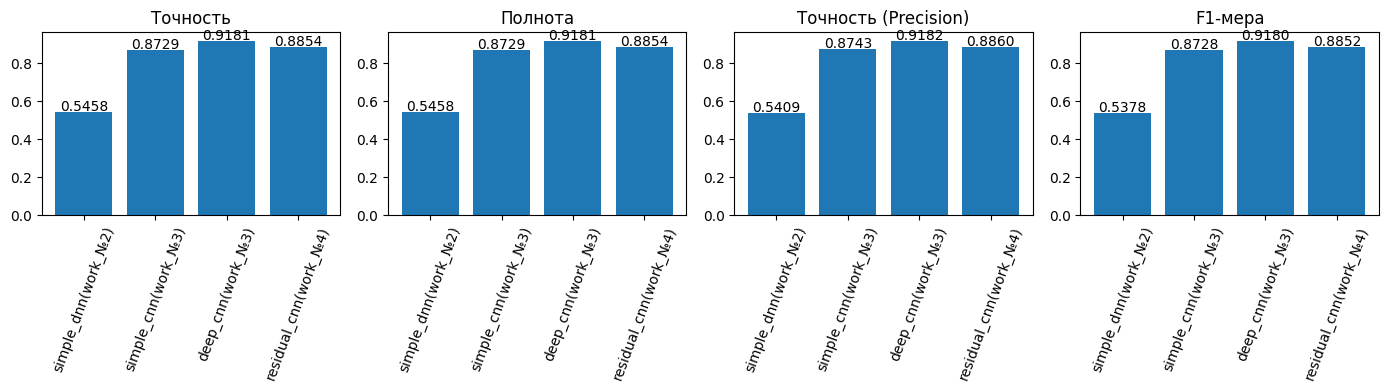

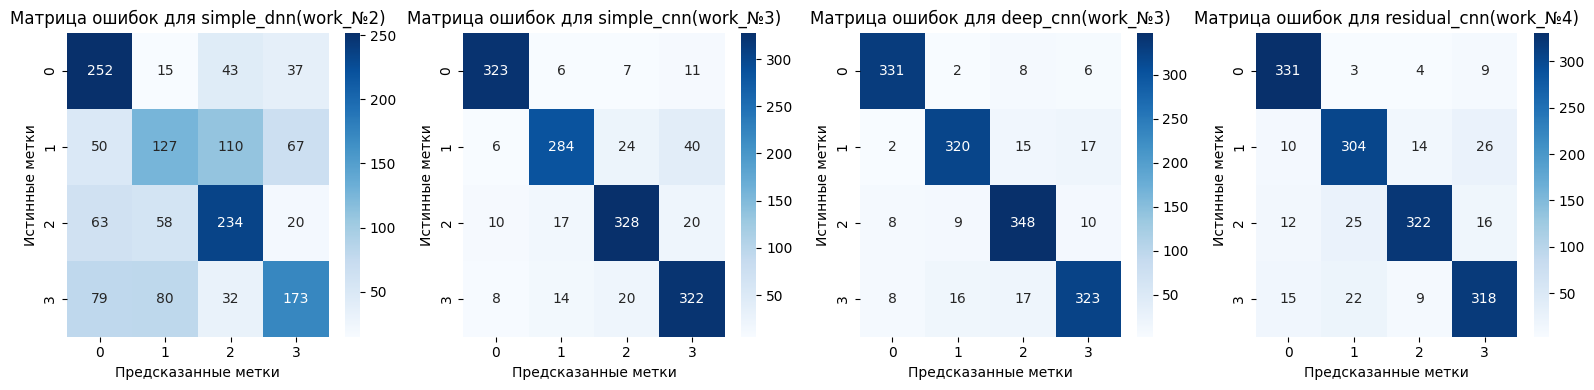


Лучшая модель по F1-мере: deep_cnn(work_№3)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results_df = pd.DataFrame({
    model_name: {
        'Точность': metrics['accuracy'],
        'Полнота': metrics['recall'],
        'Точность (Precision)': metrics['precision'],
        'F1-мера': metrics['f1'],
    }
    for model_name, metrics in results.items()
})

results_df = results_df.T

results_df_sorted = results_df.sort_values('F1-мера', ascending=False)

print("Результаты по всем моделям:")
display(results_df_sorted.style.format("{:.4f}"))
print()

plt.figure(figsize=(14, 6))
metrics_to_plot = ['Точность', 'Полнота', 'Точность (Precision)', 'F1-мера']

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 4, i+1)
    plt.bar(results_df.index, results_df[metric])
    plt.title(metric)
    plt.xticks(rotation=70)
    for j, v in enumerate(results_df[metric]):
        plt.text(j, v + 0.005, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

print()
plt.figure(figsize=(16, 4))
for i, (name, metrics) in enumerate(results.items()):
    plt.subplot(1, 4, i+1)
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок для {name}')
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')

plt.tight_layout()
plt.show()

best_model_name = results_df_sorted.index[0]
best_model = models[best_model_name]

print(f"\nЛучшая модель по F1-мере: {best_model_name}")

## **Раздел 2. Развертывание API**


1. Создать FastAPI приложение для обработки запросов с изображениями
2. Реализовать предобработку загружаемых изображений
3. Реализовать эндпоинт для классификации изображений
4. Добавить возврат предсказанного класса и вероятностей по всем классам
5. Создать файл requirements.txt с необходимыми зависимостями
6. Развернуть API на сервере с доступом из глобальной сети

https://neural-network-classification.onrender.com

https://github.com/xFlodz/neural-network-classification

## **Раздел 3. Создание интерфейса на Streamlit**



1. Разработать Streamlit-приложение со следующими функциями:
   - Возможность загрузки изображения пользователем
   - Возможность рисования изображения на холсте
   - Предобработка изображения перед отправкой на API
   - Отображение результатов классификации
   - Визуализация распределения вероятностей по классам
2. Развернуть Streamlit-приложение на платформе Streamlit Cloud

https://neural-network-classification-b9igzm9nlckywwgmzg5nn8.streamlit.app/